  <a target="_blank" href="https://colab.research.google.com/github/intro-stat-learning/ISLP_labs/blob/v2.2/Ch10-deeplearning-lab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </a>

  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/intro-stat-learning/ISLP_labs/v2.2?labpath=Ch10-deeplearning-lab.ipynb)


### Aprendizaje Profundo

Ejemplo red neuronal simple.

Podemos entonces introducir el ejemplo más directo de red neuronal que se trata del modelo logit, como lo revisamos en las notas de clase. Para ello vamos a usar una base de datos bastante popularizada que se trata de la base de datos de mnist la cuál fue compilada por Yann Le Cun entre otros expertos en AI.

La idea de esta base de datos es poder clasificar los dígitos manuscritos. Entre las siguientes opciones: (0,1,2,3,4,5,6,7,8,9). Para ello primero debemos instalar algunas librerías complementarias para el trabajo de ciencia de datos. 

La siguiente implementación de una red neuronal simple esta basado en la implementación presentada en el documento building a logistic regresison: https://machinelearningmastery.com/building-a-logistic-regression-classifier-in-pytorch/. La cuál hace una implementación más directa de la regresión logística.


In [53]:
# %pip install torchmetrics
# %pip install torchinfo
# %pip install ISLP

In [54]:
### Importamos las librerias de Pytorch.
import os
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)

from glob import glob
import json

Seed set to 0


In [55]:
path = os.path.dirname(os.getcwd())

if path == '/': # Si estamos en la raíz del sistema, entonces no es necesario agregar la carpeta datos. (Aplica en Google Colab)
    file_path = os.path.join('datos', 'forex_data.csv')
else:
    file_path = os.path.join(path,'datos', 'forex_data.csv')


In [56]:
(mnist_train,
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

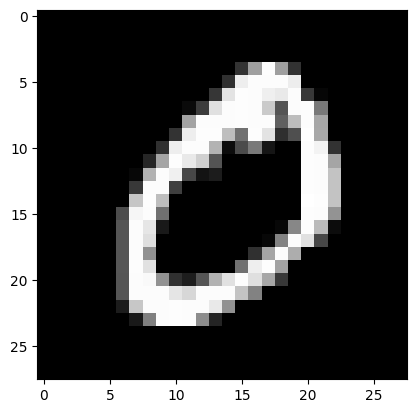

In [57]:
###
import matplotlib.pyplot as plt

##3 Podemos ver entonces una ejemplo del digito manuscrito.
img_5 = mnist_train[1][0].numpy().reshape(28, 28)
plt.imshow(img_5, cmap='gray')
plt.show()


Podemos entonces cargar los datos usando la función load Dataset con la función DataLoader con el objetivo de cargar los datos al modelo en Batches o Lotes.

In [58]:
from torch.utils.data import DataLoader
# Let's do it with a batch size of 32.
batch_size_1 = 32
train_loader = DataLoader(dataset = mnist_train, batch_size = batch_size_1, shuffle = True)
train_loader

In [59]:
# Vamos entonces a definir una red neuronal heredando de la clase de nn.Module para definir un modelo de Regresión Logísticas.
class LogisticRegression(nn.Module):
  def __init__(self, n_inputs, n_outputs):
        ### El método de súper se aplica en este caso para que la clase herede los métodos de clase padre. 
        super(LogisticRegression, self).__init__()
        ## En este caso incluirmos una capa oculta que toma n_inputs y produce n_outputs.
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    # make predictions
  def forward(self, x):
        ## Finalmente para genear los resultados de aplicar la red aplicamos la función sigmoide.
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

### En este caso instanciamos la clase con los métodos del constructor los cuáles requiren unos n_inputs de tamaño 28x28 . 
### y n_outputs de 10 dígitos que se produciran. 
n_inputs = 28*28
n_outputs = 10

log_regr = LogisticRegression(n_inputs, n_outputs)
log_regr

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

### Entrenamos el clasificador.

La red neuronal se puede entrenar con varias funciones dependiendo de la característica del output. Existen fundamentalmente dos: 

(1) El MSE. Para casos de Regresión.  

En el caso de la función de MSE su definición era la siguiente: 

$R_{i}(\theta) = \Sigma_{i = 1}^{N} (y_{i}-f_{\theta} (x_{i}))$ 

(2) La función de Cross Entropía. Para el problema particular de Clasificación que estamos queriendo resolver se define de la siguiente manera: 

$R_{i}(\theta) = -\Sigma_{i=1}^{n} \Sigma_{i=1}^{9} y_{im}log(f_{m}(x_{i})) $ 

Particularmente en la librería de PyTorch podemos definir dicha optimización siempre teniendo presentes el parámetro de backpropagation. 

El cuál podemos recuperar de las notas de clase, constituye la magnitud del cambio en los parámetros en dirección del gradiente.

$\theta^{m} = \theta^{m+1} - \rho\nabla R(\theta^{m}) $ 

Con base en la implementación presentado por Hastie, Tibshirani et Al. Mostramos entonces una implementación de una red neuronal de múltiples capas.

In [60]:
### Definimos entonces el algoritmo de optimización que será el de SGD. 
optimizer = torch.optim.SGD(log_regr.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
### Definimos el número de epochs que serán implementados en el modelo. 
epochs = 50
### Adicionalmente con propositos explicativos reservamos los valores de la función de perdida en la lista loss. 
Loss = []
### También reservamos el accuracy de cada modelo. 
acc = []
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = log_regr(images.view(-1, 28*28))
        loss = criterion(outputs, labels)
        # Loss.append(loss.item())
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())
    correct = 0
    for images, labels in mnist_test:
        outputs = log_regr(images.view(-1, 28*28))
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
    accuracy = 100 * (correct.item()) / len(mnist_test)
    acc.append(accuracy)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))


Epoch: 0. Loss: 2.2104101181030273. Accuracy: 61.07
Epoch: 1. Loss: 2.1061415672302246. Accuracy: 72.57
Epoch: 2. Loss: 2.0380632877349854. Accuracy: 76.57
Epoch: 3. Loss: 2.021063804626465. Accuracy: 78.7
Epoch: 4. Loss: 1.9599621295928955. Accuracy: 80.1
Epoch: 5. Loss: 1.9122592210769653. Accuracy: 80.93
Epoch: 6. Loss: 1.9080702066421509. Accuracy: 81.45
Epoch: 7. Loss: 1.8631993532180786. Accuracy: 81.87
Epoch: 8. Loss: 1.8526206016540527. Accuracy: 82.21
Epoch: 9. Loss: 1.8818299770355225. Accuracy: 82.56
Epoch: 10. Loss: 1.837859869003296. Accuracy: 82.76
Epoch: 11. Loss: 1.7677162885665894. Accuracy: 83.1
Epoch: 12. Loss: 1.833802342414856. Accuracy: 83.38
Epoch: 13. Loss: 1.821901798248291. Accuracy: 83.56
Epoch: 14. Loss: 1.7801607847213745. Accuracy: 83.65
Epoch: 15. Loss: 1.7475173473358154. Accuracy: 83.82
Epoch: 16. Loss: 1.8237555027008057. Accuracy: 84.09
Epoch: 17. Loss: 1.7580866813659668. Accuracy: 84.21
Epoch: 18. Loss: 1.77474844455719. Accuracy: 84.31
Epoch: 19. L

In [61]:
max_num_workers = rec_num_workers()
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)

mnist_dm

### El siguiente método separa las variables de respuesta de las variables de entrada. 
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [62]:
### Procedemos entonces con el resto de parametros 

Procedemos entonces con la definición de la clase MNIST model para la implementación de una red neuronal de múltiples capas. 

In [63]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        ### En la primera capa se hace una codificación de 28 x 28 a una codificación de un output de 256
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            # Se introduce una regularización no lineal.
            nn.ReLU(),
            # Se introduce un dropout aleatorio del 40% de las redes. 
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            # Se introduce una segunda capa que procesa el output de 256 y lo procesa en output de 128 unidades.. 
            nn.Linear(256, 128),
            # Se introduce una regularización no lineal
            nn.ReLU(),
            # Se introduce un dropout aleatorio del 30% de las undidades. 
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            # Por último se define que se generan los outputs de la primera capa que alimenatan a su vez los outputs de la segunda capa. 
            self.layer1,
            self.layer2,
            # Se comprime finalmente el output de la segunda parte en los 10 dígitos que se debía codificar. 
            nn.Linear(128, 10))
        
    def forward(self, x):
        return self._forward(x)

### En este caso no dejamos la flexibilidad del número de inputs y del número de outputs que puede generar. 
mnist_model = MNISTModel()
mnist_model

MNISTModel(
  (layer1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (_forward): Sequential(
    (0): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=256, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.4, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [64]:
mnist_model(X_).size()

torch.Size([256, 10])

In [65]:
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [66]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)
### Definimos entonces un CSVLogger con la intención de reservar los outputs del CSV. 


### Definimos entonces el objeto entrenador instanciado con base en el método de mnist_logger que definimos., 
### 
mnist_logger = CSVLogger('logs', name='MNIST')

mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])



mnist_module = SimpleModule.classification(mnist_model,
                                           num_classes=10)


### Entrenamos entonces el modelo. 
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


`Trainer.fit` stopped: `max_epochs=30` reached.


In [67]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9571999907493591
        test_loss           0.17949163913726807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.17949163913726807, 'test_accuracy': 0.9571999907493591}]

In [68]:
mnist_logger.experiment.metrics_file_path

'logs\\MNIST\\version_5\\metrics.csv'

In [69]:
path

'c:\\Users\\jcamargo\\OneDrive - FLAR\\Documentos\\CEFA_Repo_2025_Office\\CEFA2025'

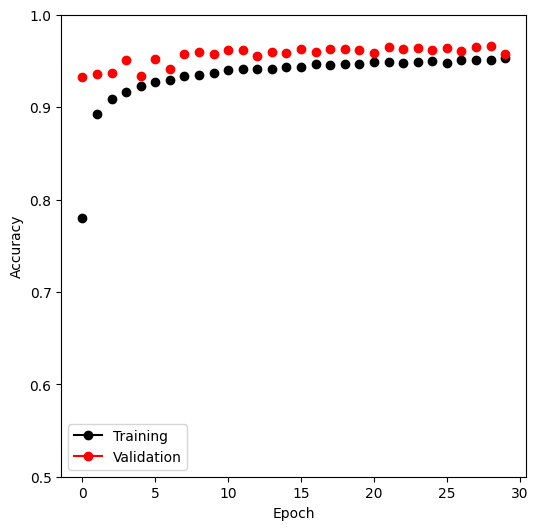

In [70]:
### Recibimos los datos registrados en el csv. 
mnist_results = pd.read_csv(os.path.join(path, "Colab", mnist_logger.experiment.metrics_file_path))
fig, ax = subplots(1, 1, figsize=(6, 6))

### Usamos una función para encontrar el gráfico con la evolución de los errores de validación y de entrenamiento. 

def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

### Finalmente graficamos el summary plot que hallamos obtenido. 
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));


Los resultados de esta regresión son comparados con los de la regresión logística. Por lo cuál en el mismo notebook se incluye una implementación de dicho modelo. 

In [71]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model,
                                         num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,
                      enable_progress_bar=False,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


`Trainer.fit` stopped: `max_epochs=30` reached.


In [72]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9203000068664551
        test_loss           0.33038607239723206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.33038607239723206, 'test_accuracy': 0.9203000068664551}]

Se encuentra entonces que los resultados de esta regresión loística logran tener un buen desempeño en los datos de prueba con un accuracy de cerca del 90%.

### Referencias. 

Las referencias empleadas para el entranamiento de los notebooks. 

Building a Logistic Regression Classifier in Pytorch: https://machinelearningmastery.com/building-a-logistic-regression-classifier-in-pytorch/. 

Trebor, Hastie et AL. Deep Learning. Disponible en: https://colab.research.google.com/github/intro-stat-learning/ISLP_labs/blob/v2.2/Ch10-deeplearning-lab.ipynb#scrollTo=6ff23014
